**Imports**

In [1]:
import shap as sh
import skmultiflow as skm
import sklearn as skl
import numpy as np
import pandas as pd
import matplotlib as mp

**Get and clean data**

In [2]:
data_path="../dat/"
column_names = ['age', 'workclass', 'finalweight', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', '50K']

train_data = pd.read_csv(filepath_or_buffer=data_path + "adult.data", sep= ", ", names=column_names, engine='python')
test_data  = pd.read_csv(filepath_or_buffer=data_path + "adult.test", sep= ", ", names=column_names, engine='python')

#Deal with ? values by replacing with the mode frequent entry in that column
attrib, counts = np.unique(train_data['workclass'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis = 0)]
train_data['workclass'] = train_data['workclass'].replace({'?': most_freq_attrib})
test_data['workclass']  = test_data['workclass'].replace({'?': most_freq_attrib})

attrib, counts = np.unique(train_data['occupation'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis = 0)]
train_data['occupation'] = train_data['occupation'].replace({'?': most_freq_attrib})
test_data['occupation']  = test_data['occupation'].replace({'?': most_freq_attrib})

attrib, counts = np.unique(train_data['native-country'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis = 0)]
train_data['native-country'] = train_data['native-country'].replace({'?': most_freq_attrib})
test_data['native-country']  = test_data['native-country'].replace({'?': most_freq_attrib})

#Replace 50k by numerical value indicating true or false
train_data['50K'] = train_data['50K'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
test_data['50K']  = test_data['50K'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

train_labels = train_data['50K']
test_labels  = test_data['50K']
train_data   = train_data.drop('50K',1)
test_data    = test_data.drop('50K', 1)

#TODO this is not a particular smart way to deal with categorical data. https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree
#['age', 'workclass', 'finalweight', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', '50K
#Turn categorical data into numerical data
le = skl.preprocessing.LabelEncoder()
attrib = np.unique(train_data['workclass'])
le.fit(attrib)
train_data['workclass'] = le.transform(train_data['workclass'])
test_data['workclass'] = le.transform(test_data['workclass'])

le1 = skl.preprocessing.LabelEncoder()
attrib = np.unique(train_data['education'])
le1.fit(attrib)
train_data['education'] = le1.transform(train_data['education'])
test_data['education'] = le1.transform(test_data['education'])

le2 = skl.preprocessing.LabelEncoder()
attrib = np.unique(train_data['marital-status'])
le2.fit(attrib)
train_data['marital-status'] = le2.transform(train_data['marital-status'])
test_data['marital-status'] = le2.transform(test_data['marital-status'])

le3 = skl.preprocessing.LabelEncoder()
attrib = np.unique(train_data['occupation'])
le3.fit(attrib)
train_data['occupation'] = le3.transform(train_data['occupation'])
test_data['occupation'] = le3.transform(test_data['occupation'])

le4 = skl.preprocessing.LabelEncoder()
attrib = np.unique(train_data['relationship'])
le4.fit(attrib)
train_data['relationship'] = le4.transform(train_data['relationship'])
test_data['relationship'] = le4.transform(test_data['relationship'])

le5 = skl.preprocessing.LabelEncoder()
attrib = np.unique(train_data['race'])
le5.fit(attrib)
train_data['race'] = le5.transform(train_data['race'])
test_data['race'] = le5.transform(test_data['race'])

le6 = skl.preprocessing.LabelEncoder()
attrib = np.unique(train_data['sex'])
le6.fit(attrib)
train_data['sex'] = le6.transform(train_data['sex'])
test_data['sex'] = le6.transform(test_data['sex'])

le7 = skl.preprocessing.LabelEncoder()
attrib = np.unique(train_data['native-country'])
le7.fit(attrib)
train_data['native-country'] = le7.transform(train_data['native-country'])
test_data['native-country'] = le7.transform(test_data['native-country'])

In [3]:
def test_accuracy(y_predict_, ys_test_):
    acc = 0.0
    for idx, elem in enumerate(ys_test_):
        if(elem == y_predict_[idx]):
            acc += 1
    acc /= len(y_predict_)
    return acc

**Train Decision Tree**

In [30]:
%%time
tree = skl.tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=1000, 
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                                       random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       min_impurity_split=None, class_weight=None)
tree.fit(train_data.to_numpy(), train_labels.to_numpy())

predicted_train_labels = tree.predict(train_data.to_numpy())
predicted_test_labels  = tree.predict(test_data.to_numpy())

Wall time: 116 ms


**Train Hoeffding Tree**

In [5]:
%%time
h_tree = skm.trees.HoeffdingTreeClassifier(max_byte_size=33554432, memory_estimate_period=1000000, grace_period=200, 
                                 split_criterion='gini', split_confidence=1e-07, tie_threshold=0.05, 
                                 binary_split=False, stop_mem_management=False, remove_poor_atts=False, 
                                 no_preprune=False, leaf_prediction='mc', nb_threshold=0, nominal_attributes=None)
h_tree.fit(train_data.to_numpy(), train_labels.to_numpy())

predicted_h_train_labels = h_tree.predict(train_data.to_numpy())
predicted_h_test_labels  = h_tree.predict(test_data.to_numpy())

Wall time: 9.22 s


**Incremental Hoeffding Tree**

In [27]:
h_tree_inc = skm.trees.HoeffdingTreeClassifier(max_byte_size=33554432, memory_estimate_period=1000000, grace_period=200, 
                                 split_criterion='gini', split_confidence=1e-07, tie_threshold=0.05, 
                                 binary_split=False, stop_mem_management=False, remove_poor_atts=False, 
                                 no_preprune=False, leaf_prediction='mc', nb_threshold=0, nominal_attributes=None)

for idx, train_point in enumerate(train_data.to_numpy()):
    y = train_labels.to_numpy()[idx]
    x = train_point.tolist()
    h_tree_inc.partial_fit([x], [y])
    
    if (idx % 5000 == 0):
        predicted_h_inc_train_labels = h_tree_inc.predict(train_data.to_numpy())
        predicted_h_inc_test_labels  = h_tree_inc.predict(test_data.to_numpy())  
        h_inc_train_accuracy = test_accuracy(predicted_h_inc_train_labels, train_labels)
        h_inc_test_accuracy  = test_accuracy(predicted_h_inc_test_labels, test_labels)
        print("Incrementally trained HoeffdingTree: train_accuracy: ", h_inc_train_accuracy)
        print("Incrementally trained HoeffdingTree: test_accuracy: ",  h_inc_test_accuracy)
    
predicted_h_inc_train_labels = h_tree_inc.predict(train_data.to_numpy())
predicted_h_inc_test_labels  = h_tree_inc.predict(test_data.to_numpy())    

Incrementally trained HoeffdingTree: train_accuracy:  0.7591904425539756
Incrementally trained HoeffdingTree: test_accuracy:  0.7637737239727289
Incrementally trained HoeffdingTree: train_accuracy:  0.7828690765025644
Incrementally trained HoeffdingTree: test_accuracy:  0.7867452859160985
Incrementally trained HoeffdingTree: train_accuracy:  0.8041522066275606
Incrementally trained HoeffdingTree: test_accuracy:  0.8041275105951723
Incrementally trained HoeffdingTree: train_accuracy:  0.82878289978809
Incrementally trained HoeffdingTree: test_accuracy:  0.8288802899084823
Incrementally trained HoeffdingTree: train_accuracy:  0.82878289978809
Incrementally trained HoeffdingTree: test_accuracy:  0.8288802899084823
Incrementally trained HoeffdingTree: train_accuracy:  0.82878289978809
Incrementally trained HoeffdingTree: test_accuracy:  0.8288802899084823
Incrementally trained HoeffdingTree: train_accuracy:  0.82878289978809
Incrementally trained HoeffdingTree: test_accuracy:  0.8288802899

**Calculate accuracy**

In [31]:
train_acc = test_accuracy(predicted_train_labels, train_labels)
test_acc  = test_accuracy(predicted_test_labels, test_labels)

h_train_accuracy = test_accuracy(predicted_h_train_labels, train_labels)
h_test_accuracy  = test_accuracy(predicted_h_test_labels, test_labels)

h_inc_train_accuracy = test_accuracy(predicted_h_inc_train_labels, train_labels)
h_inc_test_accuracy  = test_accuracy(predicted_h_inc_test_labels, test_labels)

print("Decision Tree: train_accuracy: ", train_acc)
print("Decision Tree: test_accuracy: ",  test_acc)

print("HoeffdingTree: train_accuracy: ", h_train_accuracy)
print("HoeffdingTree: test_accuracy: ",  h_test_accuracy)

print("Incrementally trained HoeffdingTree: train_accuracy: ", h_inc_train_accuracy)
print("Incrementally trained HoeffdingTree: test_accuracy: ",  h_inc_test_accuracy)

Decision Tree: train_accuracy:  0.8567918675716347
Decision Tree: test_accuracy:  0.8539401756648854
HoeffdingTree: train_accuracy:  0.8286907650256442
HoeffdingTree: test_accuracy:  0.8284503408881518
Incrementally trained HoeffdingTree: train_accuracy:  0.8286907650256442
Incrementally trained HoeffdingTree: test_accuracy:  0.8284503408881518


**Explain Model**

In [21]:
%%time
empty = np.zeros(test_data.shape)
explainer = sh.TreeExplainer(tree, empty)
shap_values = explainer.shap_values(test_data)

Passing 16281 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 32486/32562 [04:15<00:00]        

Wall time: 4min 14s


In [9]:
%%time
data_part = test_data[:40]
empty = np.zeros(data_part.shape)
h_explainer = sh.KernelExplainer(h_tree.predict, empty)
h_shap_values = h_explainer.shap_values(data_part)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



Wall time: 1min 49s


In [10]:
test_data['workclass']      = le.inverse_transform(test_data['workclass'])
test_data['education']      = le1.inverse_transform(test_data['education'])
test_data['marital-status'] = le2.inverse_transform(test_data['marital-status'])
test_data['occupation']     = le3.inverse_transform(test_data['occupation'])
test_data['relationship']   = le4.inverse_transform(test_data['relationship'])
test_data['race']           = le5.inverse_transform(test_data['race'])
test_data['sex']            = le6.inverse_transform(test_data['sex'])
test_data['native-country'] = le7.inverse_transform(test_data['native-country'])

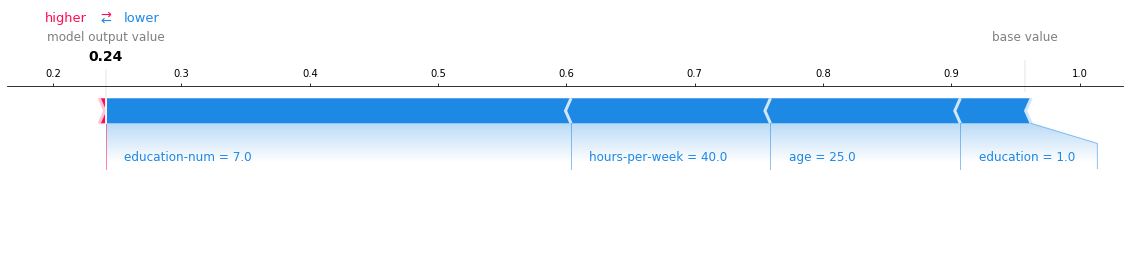

In [22]:
sh.force_plot(explainer.expected_value[0], shap_values[0][7], test_data.iloc[0,:], matplotlib=True)

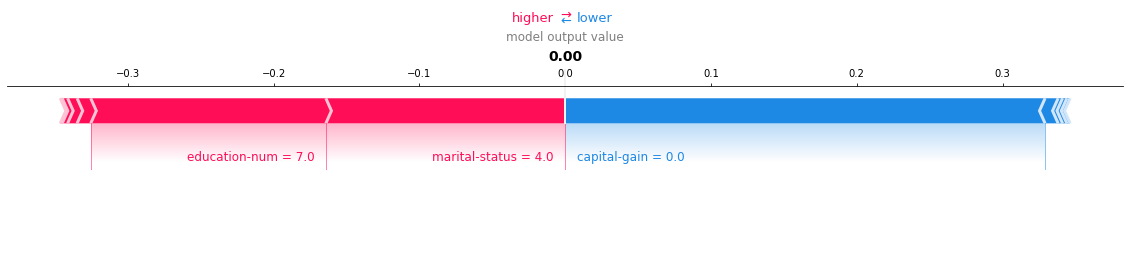

In [23]:
sh.force_plot(h_explainer.expected_value, h_shap_values[7], data_part.iloc[0,:], matplotlib=True)

In [13]:
#sh.force_plot(explainer.expected_value[0], shap_values[0], test_data[:])

In [14]:
test_data['workclass']      = le.transform(test_data['workclass'])
test_data['education']      = le1.transform(test_data['education'])
test_data['marital-status'] = le2.transform(test_data['marital-status'])
test_data['occupation']     = le3.transform(test_data['occupation'])
test_data['relationship']   = le4.transform(test_data['relationship'])
test_data['race']           = le5.transform(test_data['race'])
test_data['sex']            = le6.transform(test_data['sex'])
test_data['native-country'] = le7.transform(test_data['native-country'])

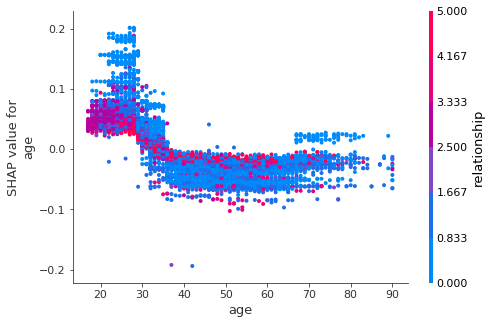

In [15]:
sh.dependence_plot("age", shap_values[0], test_data)

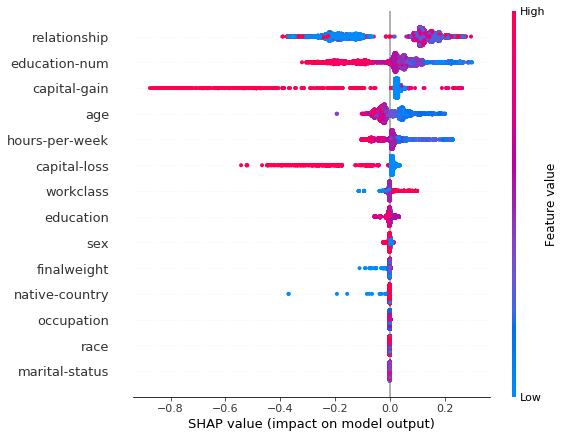

In [16]:
sh.summary_plot(shap_values[0], test_data)

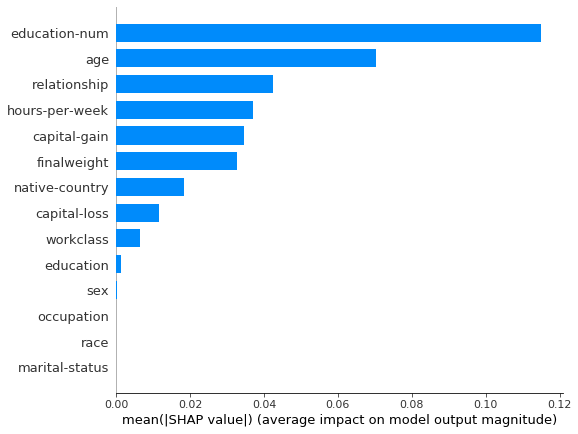

In [24]:
sh.summary_plot(shap_values[0], test_data, plot_type="bar")

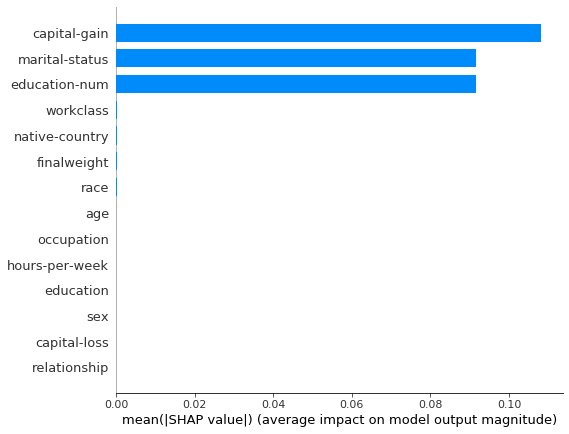

In [25]:
sh.summary_plot(h_shap_values, data_part, plot_type="bar")

In [19]:
print("Done :)")

Done :)


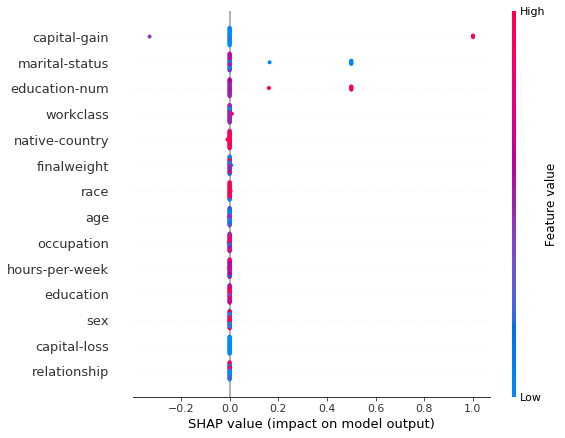

In [20]:
sh.summary_plot(h_shap_values, data_part)